In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/trafficaccidentclassificationdatasetcleaned/trafficAccidentCleanedDataset.csv
/kaggle/input/road-traffic-accidents/RTA Dataset.csv
/kaggle/input/road-traffic-accidents/cleaned.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

SMALL_SIZE = 10
MEDIUM_SIZE = 12

plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

In [3]:
rta_data = pd.read_csv("/kaggle/input/road-traffic-accidents/RTA Dataset.csv")
rta_data.head()

,Time,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,...,Vehicle_movement,Casualty_class,Sex_of_casualty,Age_band_of_casualty,Casualty_severity,Work_of_casuality,Fitness_of_casuality,Pedestrian_movement,Cause_of_accident,Accident_severity
0,17:02:00,Monday,18-30,Male,Above high school,Employee,1-2yr,Automobile,Owner,Above 10yr,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Moving Backward,Slight Injury
1,17:02:00,Monday,31-50,Male,Junior high school,Employee,Above 10yr,Public (> 45 seats),Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury
2,17:02:00,Monday,18-30,Male,Junior high school,Employee,1-2yr,Lorry (41?100Q),Owner,NaN,...,Going straight,Driver or rider,Male,31-50,3,Driver,NaN,Not a Pedestrian,Changing lane to the left,Serious Injury
3,1:06:00,Sunday,18-30,Male,Junior high school,Employee,5-10yr,Public (> 45 seats),Governmental,NaN,...,Going straight,Pedestrian,Female,18-30,3,Driver,Normal,Not a Pedestrian,Changing lane to the right,Slight Injury
4,1:06:00,Sunday,18-30,Male,Junior high school,Employee,2-5yr,NaN,Owner,5-10yrs,...,Going straight,na,na,na,na,NaN,NaN,Not a Pedestrian,Overtaking,Slight Injury


We have done investigation about which features to select and that helps to get better model with less number of features.
https://www.kaggle.com/snehalthakur1991/traffic-accident-classification-updated

In [4]:
rta_data.columns

Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Sex_of_driver',
       'Educational_level', 'Vehicle_driver_relation', 'Driving_experience',
       'Type_of_vehicle', 'Owner_of_vehicle', 'Service_year_of_vehicle',
       'Defect_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians',
       'Road_allignment', 'Types_of_Junction', 'Road_surface_type',
       'Road_surface_conditions', 'Light_conditions', 'Weather_conditions',
       'Type_of_collision', 'Number_of_vehicles_involved',
       'Number_of_casualties', 'Vehicle_movement', 'Casualty_class',
       'Sex_of_casualty', 'Age_band_of_casualty', 'Casualty_severity',
       'Work_of_casuality', 'Fitness_of_casuality', 'Pedestrian_movement',
       'Cause_of_accident', 'Accident_severity'],
      dtype='object')

In [5]:
rta_data.isna().sum()

Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                308
Casualty_class                    0
Sex_of_casualty                   0
Age_band_of_casualty              0
Casualty_severity                 0
Work_of_casuality           

In [6]:
rta_data['Accident_severity'].value_counts()

Slight Injury     10415
Serious Injury     1743
Fatal injury        158
Name: Accident_severity, dtype: int64

In [7]:
rta_data_corr = rta_data.corr()
rta_data_corr.style.background_gradient(cmap="cool")

,Number_of_vehicles_involved,Number_of_casualties
Number_of_vehicles_involved,1.000000,0.213427
Number_of_casualties,0.213427,1.000000


In [8]:
pip install sklearn-pandas==1.5.0

  Attempting uninstall: sklearn-pandas
    Found existing installation: sklearn-pandas 2.2.0
    Uninstalling sklearn-pandas-2.2.0:
      Successfully uninstalled sklearn-pandas-2.2.0
Note: you may need to restart the kernel to use updated packages.


In [9]:
# As the columns which have missing values, they are only categorical, we'll use the categorical imputer
# Importing the categorical imputer
'''from sklearn_pandas import CategoricalImputer
imputer = CategoricalImputer()

rta_data['Type_of_vehicle_new']=imputer.fit_transform(rta_data['Type_of_vehicle'])
rta_data['Type_of_vehicle'] = rta_data['Type_of_vehicle'].map({'Automobile' : 1, 'Lorry (41?100Q)' : 2 ,'Lorry (11?40Q)':2,'Long lorry':2, 'Public (12 seats)':3,'Public (13?45 seats)':3,'Public (> 45 seats)':3,'Stationwagen':4,
                                                              'Pick up upto 10Q':4, 'Taxi':4,'Turbo':4, 'Special vehicle': 4, 'Motorcycle':5,'Bajaj':5,'Bicycle':6,'Ridden horse ':7,'Other':8})
rta_data['Day_of_week'] = rta_data['Day_of_week'].map({'Monday' : 1, 'Tuesday' : 2 ,'Wednesday':3,'Thursday':4,'Friday':5, 'Saturday':6,'Sunday':7})
rta_data['Age_band_of_driver'] = rta_data['Age_band_of_driver'].map({'Under 18' : 1, '18-30' : 2 ,'31-50':3,'Over 51':4,'Unknown':5})
rta_data['Sex_of_driver'] = rta_data['Sex_of_driver'].map({'Male' : 1, 'Female' : 2 ,'Unknown':3})
rta_data['Educational_level'] = rta_data['Educational_level'].map({'Junior high school' : 1, 'Elementary school' : 2 ,'High school':3
                                                                  ,'Above high school':4,'Writing & reading':5,'Unknown':6,'Illiterate':7})
rta_data['Vehicle_driver_relation'] = rta_data['Vehicle_driver_relation'].map({'Employee' : 1, 'Owner' : 2 ,'Other':3,'Unknown':3})
rta_data['Driving_experience'] = rta_data['Driving_experience'].map({'1-2yr' : 1, '2-5yr' : 2 ,'5-10yr':3,'Unknown':3
                                                                    ,'Above 10yr':4,'Below 1yr':5,'No Licence':6,'unknown':7})
rta_data['Owner_of_vehicle'] = rta_data['Owner_of_vehicle'].map({'Owner' : 1, 'Governmental' : 2 ,'Organization':3,'Other':4})
rta_data['Service_year_of_vehicle'] = rta_data['Service_year_of_vehicle'].map({'1-2yr' : 1, '2-5yrs' : 2 ,'5-10yrs':3,'Unknown':3
                                                                    ,'Above 10yr':4,'Below 1yr':5,'unknown':6})
rta_data['Defect_of_vehicle'] = rta_data['Defect_of_vehicle'].map({'No defect' : 1})
rta_data['Defect_of_vehicle']=imputer.fit_transform(rta_data['Defect_of_vehicle'])
rta_data['Area_accident_occured'] = rta_data['Area_accident_occured'].map({'Other' : 1, 'Office areas' : 2 ,'Residential areas':3,'Unknown':4,'Church areas':5,'Industrial areas':6,'School areas':7, 'Recreational areas':8, 'Outside rural areas': 9, 'Hospital areas': 10, 'Market areas': 11, 'Rural village areas': 12,
'Rural village areasOffice areas': 13, 'Recreational areas': 14})
rta_data['Lanes_or_Medians'] = rta_data['Lanes_or_Medians'].map({'Two-way (divided with broken lines road marking)' : 1, 'Undivided Two way' : 2 ,
                                                                           'other':3,'Unknown':4,'Double carriageway (median)':5,'One way':6,
                                                                           'Two-way (divided with solid lines road marking)':7})
rta_data['Road_allignment'] = rta_data['Road_allignment'].map({'Tangent road with flat terrain' : 1, 'Tangent road with mild grade and flat terrain' : 2 ,
                                                                           'Steep grade downward with mountainous terrain':3,'Tangent road with mountainous terrain and':4,'Gentle horizontal curve':5,'Escarpments':6,
                                                                           'Sharp reverse curve':7, 'Tangent road with rolling terrain':8, 'Steep grade upward with mountainous terrain':9})
rta_data['Types_of_Junction'] = rta_data['Types_of_Junction'].map({'Y Shape' : 1, 'No junction' : 2 ,
                                                                           'Crossing':3,'Other':4,'Unknown':5,'O Shape':6,
                                                                           'T Shape':7, 'X Shape':8})
rta_data['Fitness_of_casuality'] = rta_data['Fitness_of_casuality'].map({'Normal' : 1, 'NormalNormal' : 1 ,'Deaf':2, 'Blind':3, 'Other':4})
rta_data['Work_of_casuality'] = rta_data['Work_of_casuality'].map({'Driver' : 1, 'Self-employed' : 2 ,'Employee':3, 'Unemployed':4, 'Student':5, 'Unknown':6, 'Other':7})
rta_data['Vehicle_movement'] = rta_data['Vehicle_movement'].map({'Going straight' : 1, 'Moving Backward' : 2 ,'Reversing':3, 'Turnover':4, 'Getting off':5, 'Entering a junction':6, 'Overtaking':7, 'Unknown':8, 'Stopping':9, 'U-Turn':10, 'Waiting to go':11, 'Parked':12, 'Other':13})
rta_data['Type_of_collision'] = rta_data['Type_of_collision'].map({'Vehicle with vehicle collision' : 1, 'Collision with roadside objects' : 2 ,'Collision with pedestrians':3, 'Rollover':4, 'Collision with animals':5, 'Collision with roadside-parked vehicles':6, 'Fall from vehicles':7, 'Unknown':8, 'With Train':9, 'Other':10})
rta_data['Weather_conditions'] = rta_data['Weather_conditions'].map({'Normal' : 1, 'Raining' : 2 ,'Unknown':3, 'Cloudy':4, 'Windy':5, 'Raining and Windy':6, 'Fog or mist':7, 'Other':8})
rta_data['Light_conditions'] = rta_data['Light_conditions'].map({'Daylight' : 1, 'Darkness - lights lit' : 2 ,'Darkness - no lighting':3, 'Darkness - lights unlit':4})
rta_data['Road_surface_conditions'] = rta_data['Road_surface_conditions'].map({'Dry' : 1, 'Wet or damp' : 2 ,'Snow':3, 'Flood over 3cm. deep':4})
rta_data['Road_surface_type'] = rta_data['Road_surface_type'].map({'Asphalt roads' : 1, 'Earth roads' : 2 ,'Other':3, 'Gravel roads':4})
rta_data['Accident_severity'] = rta_data['Accident_severity'].map({'Slight Injury' : 1, 'Serious Injury' : 2 ,'Fatal injury':3})'''

"from sklearn_pandas import CategoricalImputer\nimputer = CategoricalImputer()\n\nrta_data['Type_of_vehicle_new']=imputer.fit_transform(rta_data['Type_of_vehicle'])\nrta_data['Type_of_vehicle'] = rta_data['Type_of_vehicle'].map({'Automobile' : 1, 'Lorry (41?100Q)' : 2 ,'Lorry (11?40Q)':2,'Long lorry':2, 'Public (12 seats)':3,'Public (13?45 seats)':3,'Public (> 45 seats)':3,'Stationwagen':4,\n                                                              'Pick up upto 10Q':4, 'Taxi':4,'Turbo':4, 'Special vehicle': 4, 'Motorcycle':5,'Bajaj':5,'Bicycle':6,'Ridden horse ':7,'Other':8})\nrta_data['Day_of_week'] = rta_data['Day_of_week'].map({'Monday' : 1, 'Tuesday' : 2 ,'Wednesday':3,'Thursday':4,'Friday':5, 'Saturday':6,'Sunday':7})\nrta_data['Age_band_of_driver'] = rta_data['Age_band_of_driver'].map({'Under 18' : 1, '18-30' : 2 ,'31-50':3,'Over 51':4,'Unknown':5})\nrta_data['Sex_of_driver'] = rta_data['Sex_of_driver'].map({'Male' : 1, 'Female' : 2 ,'Unknown':3})\nrta_data['Educational_leve

In [10]:
cleaned_data = pd.read_csv('../input/trafficaccidentclassificationdatasetcleaned/trafficAccidentCleanedDataset.csv')

In [11]:
cleaned_data.head()

,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,Defect_of_vehicle,Road_allignment,Road_surface_type,Weather_conditions,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Casualty_severity,Work_of_casuality,Cause_of_accident,Accident_severity
0,1,2,4,1,1.0,1,4,1,1,1.0,1.0,6,2,2,0.0,1,2,1
1,1,3,1,4,3.0,1,3,1,1,1.0,1.0,1,2,2,0.0,1,7,1
2,1,2,1,1,2.0,1,3,1,1,1.0,1.0,2,2,2,3.0,1,8,2
3,7,2,1,3,3.0,2,3,1,2,2.0,1.0,1,2,2,3.0,1,9,1
4,7,2,1,2,1.0,1,3,1,1,1.0,1.0,1,2,2,0.0,1,7,1


In [12]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Day_of_week                  12316 non-null  int64  
 1   Age_band_of_driver           12316 non-null  int64  
 2   Educational_level            12316 non-null  int64  
 3   Driving_experience           12316 non-null  int64  
 4   Type_of_vehicle              12316 non-null  float64
 5   Owner_of_vehicle             12316 non-null  int64  
 6   Service_year_of_vehicle      12316 non-null  int64  
 7   Defect_of_vehicle            12316 non-null  int64  
 8   Road_allignment              12316 non-null  int64  
 9   Road_surface_type            12316 non-null  float64
 10  Weather_conditions           12316 non-null  float64
 11  Type_of_collision            12316 non-null  int64  
 12  Number_of_vehicles_involved  12316 non-null  int64  
 13  Number_of_casual

In [13]:
cleaned_data = cleaned_data.astype(int)


In [14]:
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype
---  ------                       --------------  -----
 0   Day_of_week                  12316 non-null  int64
 1   Age_band_of_driver           12316 non-null  int64
 2   Educational_level            12316 non-null  int64
 3   Driving_experience           12316 non-null  int64
 4   Type_of_vehicle              12316 non-null  int64
 5   Owner_of_vehicle             12316 non-null  int64
 6   Service_year_of_vehicle      12316 non-null  int64
 7   Defect_of_vehicle            12316 non-null  int64
 8   Road_allignment              12316 non-null  int64
 9   Road_surface_type            12316 non-null  int64
 10  Weather_conditions           12316 non-null  int64
 11  Type_of_collision            12316 non-null  int64
 12  Number_of_vehicles_involved  12316 non-null  int64
 13  Number_of_casualties         12316 non-null  i

Univariate Analysis

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


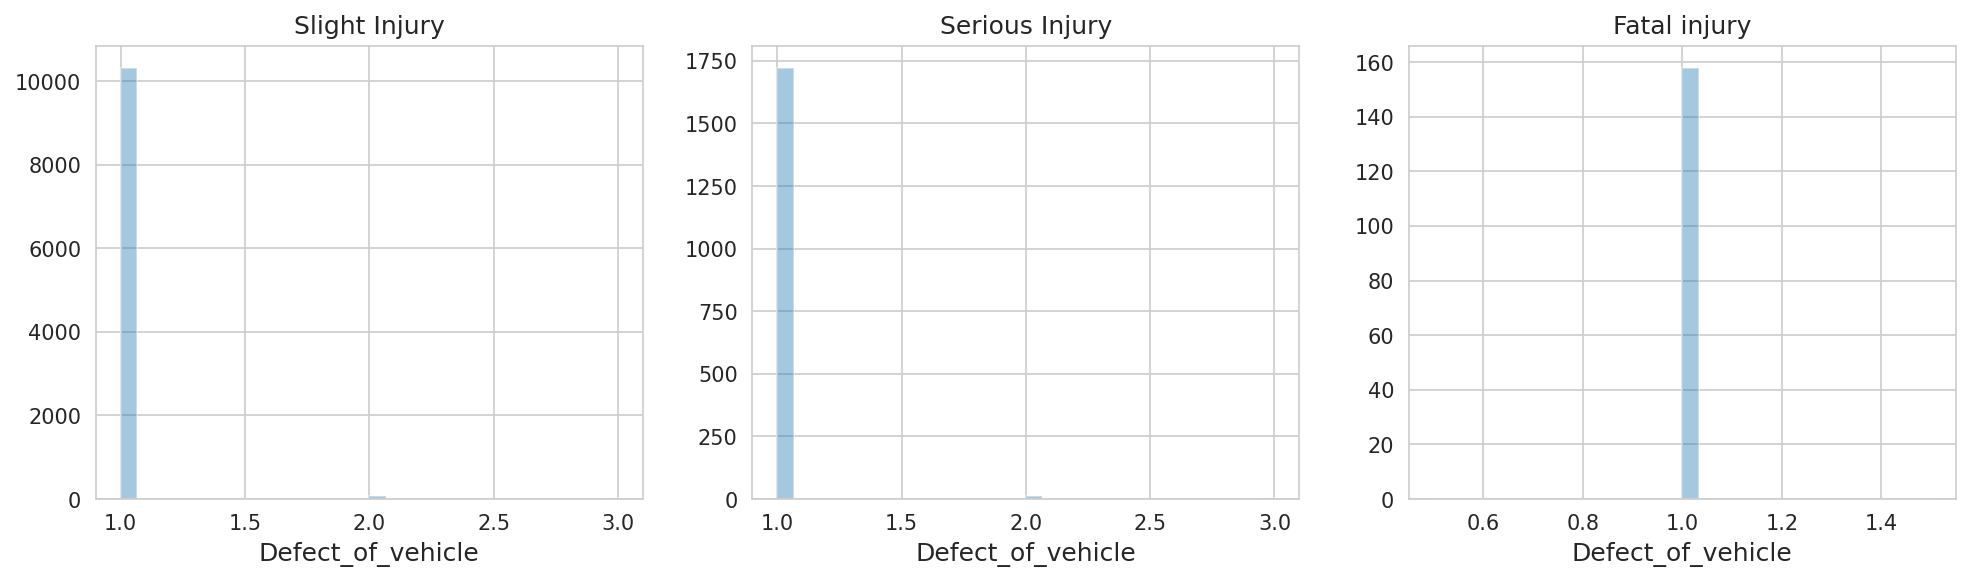

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(16, 4))
ax = sns.distplot(cleaned_data[cleaned_data['Accident_severity']==1].Defect_of_vehicle, bins = 30, ax = axes[0], kde = False)
ax.set_title('Slight Injury')
ax = sns.distplot(cleaned_data[cleaned_data['Accident_severity']==2].Defect_of_vehicle, bins = 30, ax = axes[1], kde = False)
ax.set_title('Serious Injury')
ax = sns.distplot(cleaned_data[cleaned_data['Accident_severity']==3].Defect_of_vehicle, bins = 30, ax = axes[2], kde = False)
ax = ax.set_title('Fatal injury')

In [16]:
rta_data['Accident_severity'].value_counts()

Slight Injury     10415
Serious Injury     1743
Fatal injury        158
Name: Accident_severity, dtype: int64

In [17]:
cleaned_data.columns

Index(['Day_of_week', 'Age_band_of_driver', 'Educational_level',
       'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle',
       'Service_year_of_vehicle', 'Defect_of_vehicle', 'Road_allignment',
       'Road_surface_type', 'Weather_conditions', 'Type_of_collision',
       'Number_of_vehicles_involved', 'Number_of_casualties',
       'Casualty_severity', 'Work_of_casuality', 'Cause_of_accident',
       'Accident_severity'],
      dtype='object')

Text(0.5, 1.0, 'Slight Injury')

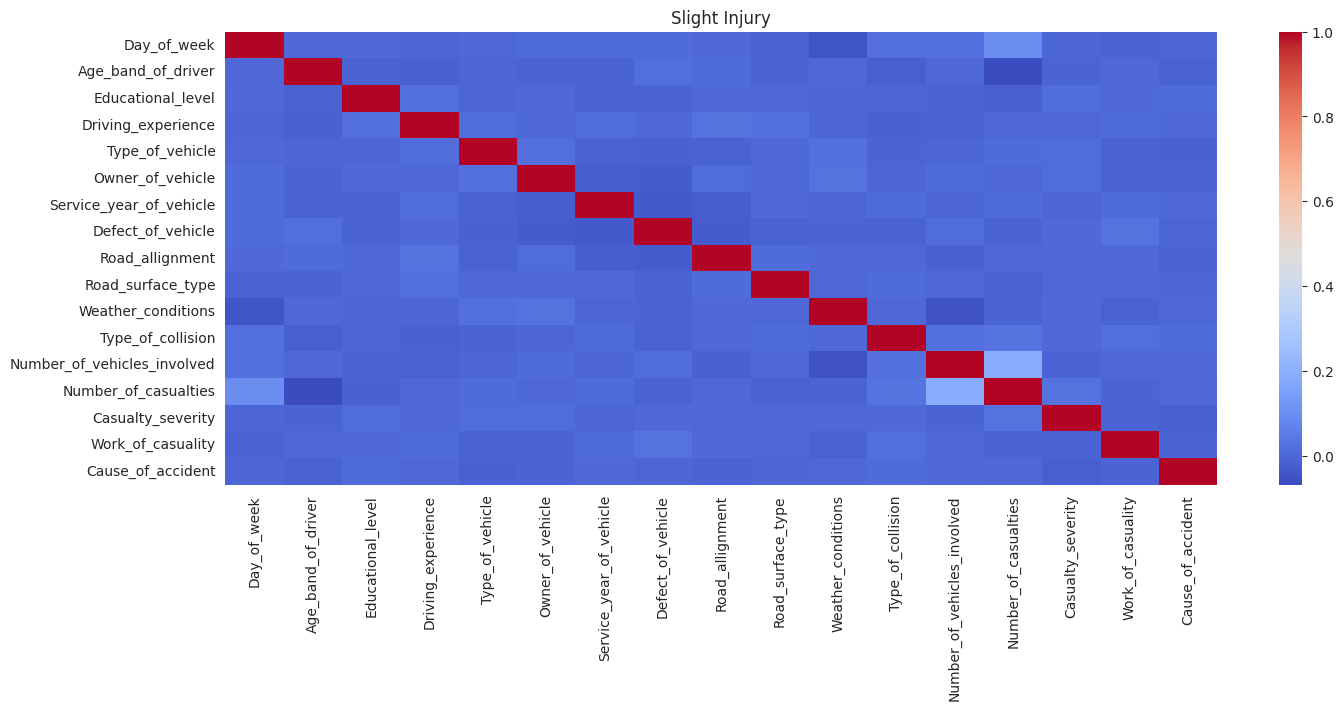

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 6))
fig.set_dpi(100)
ax = sns.heatmap(cleaned_data[cleaned_data['Accident_severity']==1][['Day_of_week', 'Age_band_of_driver', 'Educational_level',
       'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle',
       'Service_year_of_vehicle', 'Defect_of_vehicle', 'Road_allignment',
       'Road_surface_type', 'Weather_conditions', 'Type_of_collision',
       'Number_of_vehicles_involved', 'Number_of_casualties',
       'Casualty_severity', 'Work_of_casuality', 'Cause_of_accident']].corr(), cmap='coolwarm')
ax.set_title('Slight Injury')

Text(0.5, 1.0, 'Serious Injury')

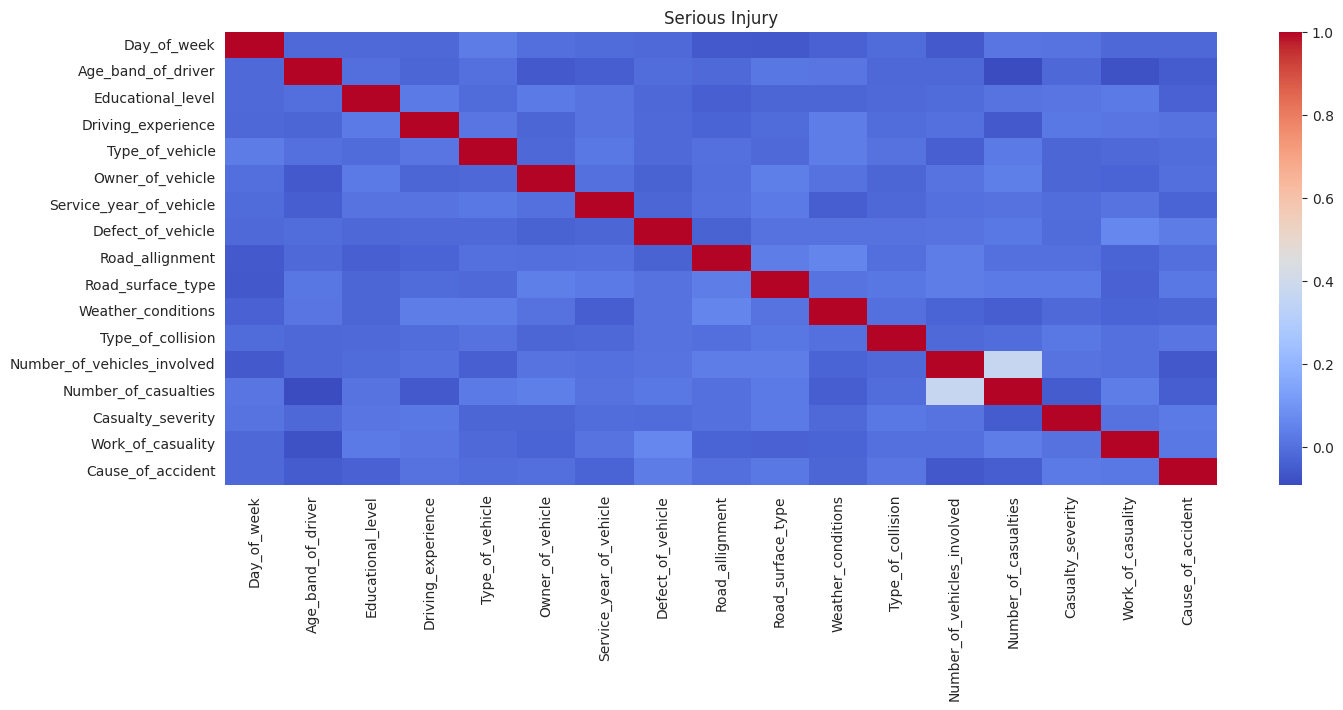

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 6))
fig.set_dpi(100)
ax = sns.heatmap(cleaned_data[cleaned_data['Accident_severity']==2][['Day_of_week', 'Age_band_of_driver', 'Educational_level',
       'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle',
       'Service_year_of_vehicle', 'Defect_of_vehicle', 'Road_allignment',
       'Road_surface_type', 'Weather_conditions', 'Type_of_collision',
       'Number_of_vehicles_involved', 'Number_of_casualties',
       'Casualty_severity', 'Work_of_casuality', 'Cause_of_accident']].corr(), cmap='coolwarm')
ax.set_title('Serious Injury')


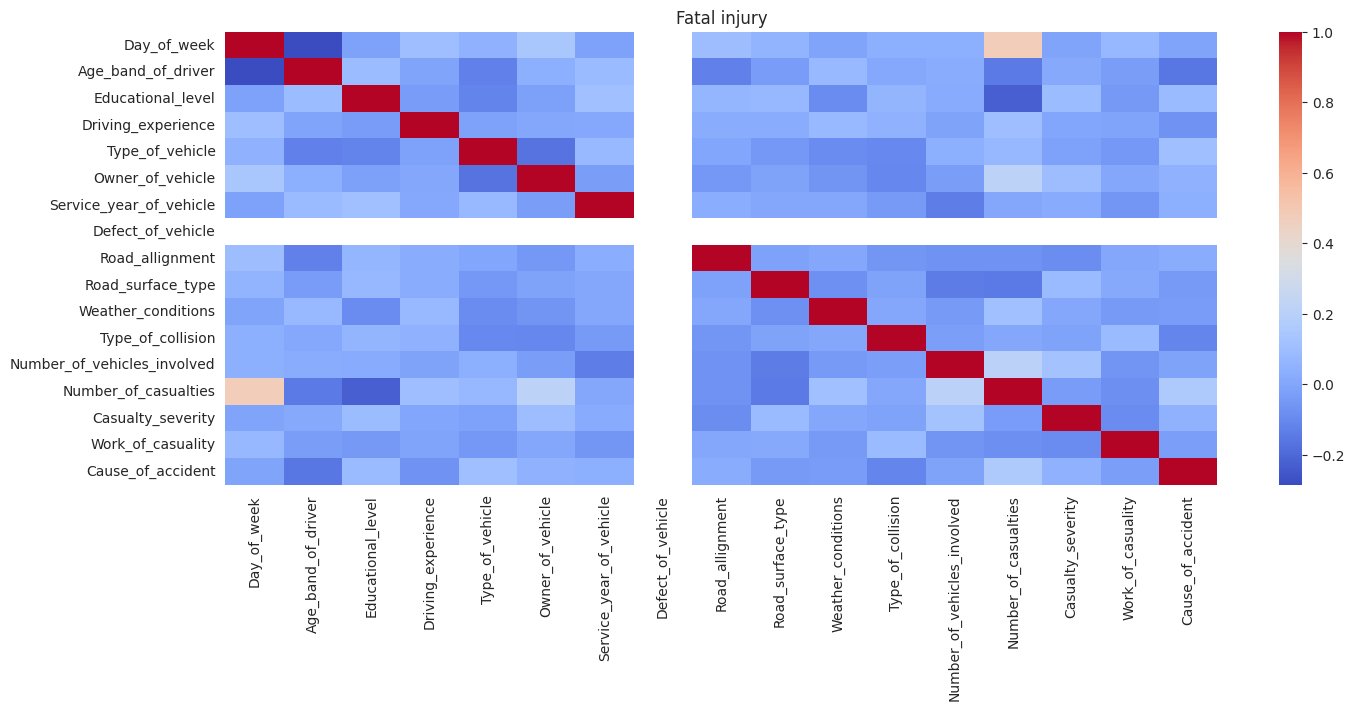

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(16, 6))
fig.set_dpi(100)
ax = sns.heatmap(cleaned_data[cleaned_data['Accident_severity']==3][['Day_of_week', 'Age_band_of_driver', 'Educational_level',
       'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle',
       'Service_year_of_vehicle', 'Defect_of_vehicle', 'Road_allignment',
       'Road_surface_type', 'Weather_conditions', 'Type_of_collision',
       'Number_of_vehicles_involved', 'Number_of_casualties',
       'Casualty_severity', 'Work_of_casuality', 'Cause_of_accident']].corr(), cmap='coolwarm')
ax = ax.set_title('Fatal injury')

PCA

In [21]:
cleaned_data_fe = cleaned_data

# encode class labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(cleaned_data_fe['Accident_severity'])
cleaned_data_fe['Accident_severity'] = y_encoded

# Principal Component Analysis
pca = PCA(n_components=3)
ugriz = pca.fit_transform(cleaned_data_fe[['Day_of_week', 'Age_band_of_driver', 'Educational_level',
       'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle',
       'Service_year_of_vehicle', 'Defect_of_vehicle', 'Road_allignment',
       'Road_surface_type', 'Weather_conditions', 'Type_of_collision',
       'Number_of_vehicles_involved', 'Number_of_casualties',
       'Casualty_severity', 'Work_of_casuality', 'Cause_of_accident']])

# update dataframe 
cleaned_data_fe = pd.concat((cleaned_data_fe, pd.DataFrame(ugriz)), axis=1)
cleaned_data_fe.rename({0: 'PCA_1', 1: 'PCA_2', 2: 'PCA_3'}, axis=1, inplace = True)
'''cleaned_data_fe.drop(['Day_of_week', 'Age_band_of_driver', 'Educational_level',
       'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle',
       'Service_year_of_vehicle', 'Defect_of_vehicle', 'Road_allignment',
       'Road_surface_type', 'Weather_conditions', 'Type_of_collision',
       'Number_of_vehicles_involved', 'Number_of_casualties',
       'Casualty_severity', 'Work_of_casuality', 'Cause_of_accident'], axis=1, inplace=True)'''
cleaned_data_fe.head()

,Day_of_week,Age_band_of_driver,Educational_level,Driving_experience,Type_of_vehicle,Owner_of_vehicle,Service_year_of_vehicle,Defect_of_vehicle,Road_allignment,Road_surface_type,...,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Casualty_severity,Work_of_casuality,Cause_of_accident,Accident_severity,PCA_1,PCA_2,PCA_3
0,1,2,4,1,1,1,4,1,1,1,...,6,2,2,0,1,2,0,-4.540152,-1.920754,-2.755430
1,1,3,1,4,3,1,3,1,1,1,...,1,2,2,0,1,7,0,0.428226,0.186454,-2.895595
2,1,2,1,1,2,1,3,1,1,1,...,2,2,2,3,1,8,1,1.428256,-0.810659,-2.828866
3,7,2,1,3,3,2,3,1,2,2,...,1,2,2,3,1,9,0,2.397626,0.381128,3.089894
4,7,2,1,2,1,1,3,1,1,1,...,1,2,2,0,1,7,0,0.428005,-1.666973,3.158317


In [22]:
scaler = MinMaxScaler()
cleaned_data_scl = scaler.fit_transform(cleaned_data_fe.drop('Accident_severity', axis=1))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_data_scl, cleaned_data_fe['Accident_severity'], test_size=0.33, shuffle=True)

In [24]:
knn = KNeighborsClassifier()
training_start = time.perf_counter()
knn.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = knn.predict(X_test)
prediction_end = time.perf_counter()
acc_knn = (preds == y_test).sum().astype(float) / len(preds)*100
knn_train_time = training_end-training_start
knn_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: %3.2f" % (acc_knn))
print("Time consumed for training: %4.3f seconds" % (knn_train_time))
print("Time consumed for prediction: %6.5f seconds" % (knn_prediction_time))

Scikit-Learn's K Nearest Neighbors Classifier's prediction accuracy is: 82.88
Time consumed for training: 0.039 seconds
Time consumed for prediction: 1.14267 seconds


In [25]:
from sklearn.preprocessing import MaxAbsScaler
scaler_gnb = MaxAbsScaler()
sdss = scaler_gnb.fit_transform(cleaned_data_fe.drop('Accident_severity', axis=1))
X_train_gnb, X_test_gnb, y_train_gnb, y_test_gnb = train_test_split(sdss, cleaned_data_fe['Accident_severity'], test_size=0.33, shuffle=True)

gnb = GaussianNB()
training_start = time.perf_counter()
gnb.fit(X_train_gnb, y_train_gnb)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = gnb.predict(X_test_gnb)
prediction_end = time.perf_counter()
acc_gnb = (preds == y_test_gnb).sum().astype(float) / len(preds)*100
gnb_train_time = training_end-training_start
gnb_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: %3.2f" % (acc_gnb))
print("Time consumed for training: %4.3f seconds" % (gnb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (gnb_prediction_time))

Scikit-Learn's Gaussian Naive Bayes Classifier's prediction accuracy is: 13.09
Time consumed for training: 0.004 seconds
Time consumed for prediction: 0.00398 seconds


In [26]:
xgb = XGBClassifier(n_estimators=100)
training_start = time.perf_counter()
xgb.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = xgb.predict(X_test)
prediction_end = time.perf_counter()
acc_xgb = (preds == y_test).sum().astype(float) / len(preds)*100
xgb_train_time = training_end-training_start
xgb_prediction_time = prediction_end-prediction_start
print("XGBoost's prediction accuracy is: %3.2f" % (acc_xgb))
print("Time consumed for training: %4.3f" % (xgb_train_time))
print("Time consumed for prediction: %6.5f seconds" % (xgb_prediction_time))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:16:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost's prediction accuracy is: 84.65
Time consumed for training: 2.596
Time consumed for prediction: 0.01626 seconds


In [27]:
rfc = RandomForestClassifier(n_estimators=10)
training_start = time.perf_counter()
rfc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = rfc.predict(X_test)
prediction_end = time.perf_counter()
acc_rfc = (preds == y_test).sum().astype(float) / len(preds)*100
rfc_train_time = training_end-training_start
rfc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Random Forest Classifier's prediction accuracy is: %3.2f" % (acc_rfc))
print("Time consumed for training: %4.3f seconds" % (rfc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (rfc_prediction_time))

Scikit-Learn's Random Forest Classifier's prediction accuracy is: 84.06
Time consumed for training: 0.174 seconds
Time consumed for prediction: 0.01043 seconds


In [28]:
svc = SVC()
training_start = time.perf_counter()
svc.fit(X_train, y_train)
training_end = time.perf_counter()
prediction_start = time.perf_counter()
preds = svc.predict(X_test)
prediction_end = time.perf_counter()
acc_svc = (preds == y_test).sum().astype(float) / len(preds)*100
svc_train_time = training_end-training_start
svc_prediction_time = prediction_end-prediction_start
print("Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: %3.2f" % (acc_svc))
print("Time consumed for training: %4.3f seconds" % (svc_train_time))
print("Time consumed for prediction: %6.5f seconds" % (svc_prediction_time))

Scikit-Learn's Support Vector Machine Classifier's prediction accuracy is: 84.55
Time consumed for training: 3.800 seconds
Time consumed for prediction: 0.56049 seconds


In [29]:
results = pd.DataFrame({
    'Model': ['KNN', 'Naive Bayes', 
              'XGBoost', 'Random Forest', 'SVC'],
    'Score': [acc_knn, acc_gnb, acc_xgb, acc_rfc, acc_svc],
    'Runtime Training': [knn_train_time, gnb_train_time, xgb_train_time, rfc_train_time, 
                         svc_train_time],
    'Runtime Prediction': [knn_prediction_time, gnb_prediction_time, xgb_prediction_time, rfc_prediction_time,
                          svc_prediction_time]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score,Runtime Training,Runtime Prediction
Model,,,
XGBoost,84.649446,2.595678,0.016259
SVC,84.551046,3.800021,0.560489
Random Forest,84.059041,0.173530,0.010427
KNN,82.878229,0.038727,1.142673
Naive Bayes,13.087331,0.003785,0.003984


In [30]:
from sklearn.model_selection import cross_val_score
rfc_cv = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.84503632 0.84484848 0.84484848 0.84121212 0.84242424 0.84848485
 0.84484848 0.84727273 0.84363636 0.84969697]
Mean: 0.8452309046885318
Standard Deviation: 0.0024849559225785583


In [31]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

[12:16:25] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:16:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:16:30] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:16:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:16:35] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [32]:
importances = pd.DataFrame({
    'Feature': cleaned_data_fe.drop('Accident_severity', axis=1).columns,
    'Importance': xgb.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
importances = importances.set_index('Feature')
importances

,Importance
Feature,
Number_of_vehicles_involved,0.100424
Number_of_casualties,0.067175
PCA_3,0.054458
Owner_of_vehicle,0.051291
Work_of_casuality,0.050803
Day_of_week,0.050261
Age_band_of_driver,0.050156
PCA_2,0.049708
PCA_1,0.049475


<AxesSubplot:xlabel='Feature'>

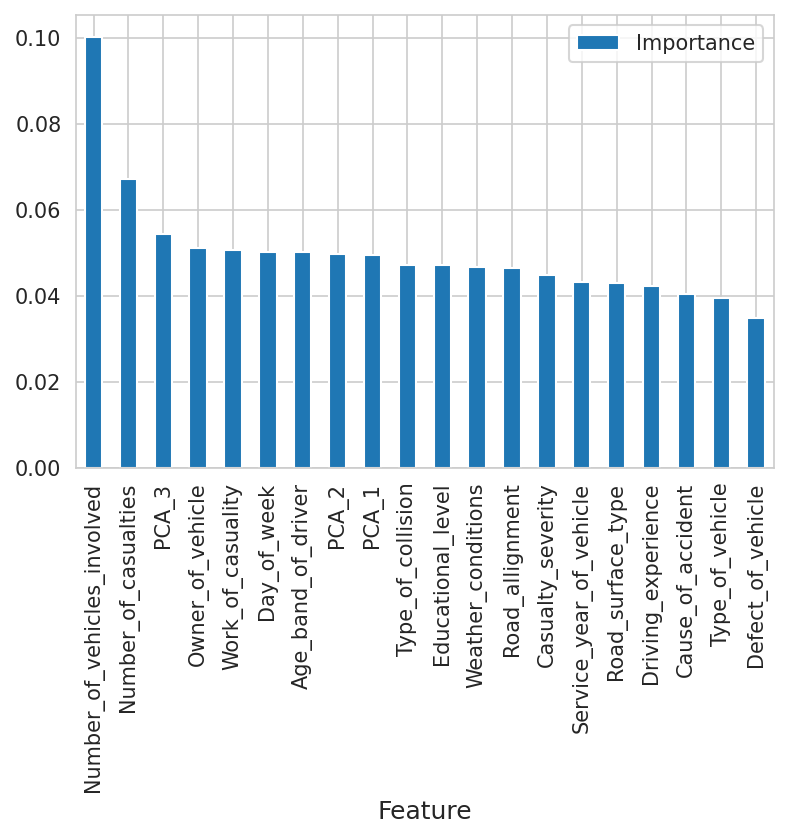

In [33]:
importances.plot.bar()

XGBoost - Testing optimal hyperparameters
The following model implements the best performing model with optimal parameters evaluated by the hyperparameter tuning. We will expect the model to perform even better than before.

Analytics Vidhya presented a really nice guide for tuning XGBoost.

Please read more: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [34]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_data.drop('Accident_severity', axis=1), cleaned_data['Accident_severity'],
                                                   test_size=0.33, shuffle=True)

In [35]:
xgboost = XGBClassifier(max_depth=3, learning_rate=0.005, n_estimators=100, gamma=0, 
                        min_child_weight=1, subsample=0.8, colsample_bytree=0.8, reg_alpha=0.005)

xgboost.fit(X_train, y_train)
preds = xgboost.predict(X_test)

accuracy = (preds == y_test).sum().astype(float) / len(preds)*100

print("XGBoost's prediction accuracy WITH optimal hyperparameters is: %3.2f" % (accuracy))

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:16:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost's prediction accuracy WITH optimal hyperparameters is: 84.31


In [36]:
xgb_cv = XGBClassifier(n_estimators=100)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:16:52] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:16:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:16:55] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:16:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

XGBoost - Evaluation
Confusion Matrix

In [37]:
unique, counts = np.unique(cleaned_data['Accident_severity'], return_counts=True)
dict(zip(unique, counts))

{0: 10415, 1: 1743, 2: 158}

In [38]:
predictions = cross_val_predict(xgb, cleaned_data.drop('Accident_severity', axis=1), cleaned_data['Accident_severity'], cv=3)
confusion_matrix(cleaned_data['Accident_severity'], predictions)

/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:17:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:17:10] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:17:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([[10170,   232,    13],
       [ 1613,   128,     2],
       [  145,     8,     5]])

The first row shows that out of 10415 stars, 10170 were classified correctly as Slight Injury. 232 Accident_severity were classified incorrectly as Serious Injury and 13 Accident_severity were classified incorrectly as quasars.

The second row shows out of 1743 quasars 1613 were classified correctly. 128 qsos were classified incorrectly as stars and 2 quasar was classified as galaxy.

The last row tells us that out of 158 galaxies 145 were classified correctly.. 8 galaxies were classified incorrectly as star.

In total:

We have only 64 objects which were classified incorrectly. Most of the objects were recognized as what they are.

Precision & Recall

In [39]:
print("Precision:", precision_score(cleaned_data['Accident_severity'], predictions, average='micro'))
print("Recall:",recall_score(cleaned_data['Accident_severity'], predictions, average='micro'))

Precision: 0.8365540759987009
Recall: 0.8365540759987009


F1-Score

One can combine precision and recall into one score, which is called the F-score. The F-score is computed with the harmonic mean of precision and recall. Note that it assigns much more weight to low values. As a result of that, the classifier will only get a high F-score, if both recall and precision are high.

In [40]:
print("F1-Score:", f1_score(cleaned_data['Accident_severity'], predictions, average='micro'))


F1-Score: 0.8365540759987009
